In [18]:
import pandas as pd

file_path = r"C:\Users\lebda\Downloads\archive\matches.csv"

df = pd.read_csv(file_path)

print(df.head())
print(df.info())

df.drop(columns=["Notes", "Unnamed: 0", "Match Report"], inplace = True) #unnecessary columns for analysis
df.isnull().sum() #shows how many null values we have
print(df.columns)

   Unnamed: 0        Date   Time            Comp        Round  Day Venue  \
0           1  2023-08-11  20:00  Premier League  Matchweek 1  Fri  Away   
1           3  2023-08-19  20:00  Premier League  Matchweek 2  Sat  Home   
2           4  2023-08-27  14:00  Premier League  Matchweek 3  Sun  Away   
3           5  2023-09-02  15:00  Premier League  Matchweek 4  Sat  Home   
4           6  2023-09-16  15:00  Premier League  Matchweek 5  Sat  Away   

  Result  GF  GA  ...  Match Report  Notes    Sh   SoT  Dist   FK PK PKatt  \
0      W   3   0  ...  Match Report    NaN  17.0   8.0  13.9  0.0  0     0   
1      W   1   0  ...  Match Report    NaN  14.0   4.0  17.9  0.0  0     0   
2      W   2   1  ...  Match Report    NaN  29.0   9.0  17.3  2.0  0     1   
3      W   5   1  ...  Match Report    NaN   6.0   4.0  14.8  0.0  1     1   
4      W   3   1  ...  Match Report    NaN  29.0  13.0  16.4  1.0  0     0   

  Season            Team  
0   2024  ManchesterCity  
1   2024  Manchester

In [21]:
df.columns = df.columns.str.lower().str.replace(" ","_") #stripped names of the columns
print(df.columns)
df.duplicated(subset=["date", "team", "opponent"]).sum()
df["venue"] = df["venue"].str.strip()
df["venue"] = df["venue"].astype("category") #stripped entries in venue
df["venue"].unique()
df.info()
#cleans the inputs of spaces that would make some inputs unique and somewhat "hidden" from functions

Index(['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation',
       'referee', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'season', 'team'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   date        760 non-null    object  
 1   time        760 non-null    object  
 2   comp        760 non-null    object  
 3   round       760 non-null    object  
 4   day         760 non-null    object  
 5   venue       760 non-null    category
 6   result      760 non-null    object  
 7   gf          760 non-null    int64   
 8   ga          760 non-null    int64   
 9   opponent    760 non-null    object  
 10  xg          760 non-null    float64 
 11  xga         760 non-null    float64 
 12  poss        760 non-null    float64 
 13  att

In [23]:
df["result"].unique()

array(['W', 'L', 'D'], dtype=object)

In [24]:
def match_result(row):
    if row["result"] == 'W':
        return 1
    elif row["result"] == 'L':
        return -1
    else:
        return 0
df["match_result"] = df.apply(match_result, axis=1)
df["match_result"].value_counts()
#converts wins to numbers so that the machine can read them

match_result
 1    298
-1    298
 0    164
Name: count, dtype: int64

In [27]:
df["recent_form"] = df.groupby("team")["match_result"].rolling(5).mean().reset_index(0, drop=True)
df[["team", "date", "match_result", "recent_form"]].head(10) #first 4 games will be NaN since there is anot a five game sample to work with yet

,team,date,match_result,recent_form
0,ManchesterCity,2023-08-11,1,NaN
1,ManchesterCity,2023-08-19,1,NaN
2,ManchesterCity,2023-08-27,1,NaN
3,ManchesterCity,2023-09-02,1,NaN
4,ManchesterCity,2023-09-16,1,1.0
5,ManchesterCity,2023-09-23,1,1.0
6,ManchesterCity,2023-09-30,-1,0.6
7,ManchesterCity,2023-10-08,-1,0.2
8,ManchesterCity,2023-10-21,1,0.2
9,ManchesterCity,2023-10-29,1,0.2


In [30]:
df["avg_goals"] = df.groupby("team")["gf"].expanding().mean().reset_index(0, drop=True)
df["avg_goals_against"] = df.groupby("team")["ga"].expanding().mean().reset_index(0, drop=True)
df["avg_shots"] = df.groupby("team")["sh"].expanding().mean().reset_index(0, drop=True)
df["avg_poss"] = df.groupby("team")["poss"].expanding().mean().reset_index(0, drop=True)
df[["team", "date", "gf", "ga", "sh", "poss", "avg_goals", "avg_goals_against", "avg_shots", "avg_poss"]].head(10)
#each gameweek, the average of all of these stats will update based on the previous matches

,team,date,gf,ga,sh,poss,avg_goals,avg_goals_against,avg_shots,avg_poss
0,ManchesterCity,2023-08-11,3,0,17.0,65.0,3.000000,0.000000,17.000000,65.000000
1,ManchesterCity,2023-08-19,1,0,14.0,59.0,2.000000,0.000000,15.500000,62.000000
2,ManchesterCity,2023-08-27,2,1,29.0,79.0,2.000000,0.333333,20.000000,67.666667
3,ManchesterCity,2023-09-02,5,1,6.0,68.0,2.750000,0.500000,16.500000,67.750000
4,ManchesterCity,2023-09-16,3,1,29.0,68.0,2.800000,0.600000,19.000000,67.800000
5,ManchesterCity,2023-09-23,2,0,7.0,57.0,2.666667,0.500000,17.000000,66.000000
6,ManchesterCity,2023-09-30,1,2,23.0,68.0,2.428571,0.714286,17.857143,66.285714
7,ManchesterCity,2023-10-08,0,1,4.0,51.0,2.125000,0.750000,16.125000,64.375000
8,ManchesterCity,2023-10-21,2,1,10.0,55.0,2.111111,0.777778,15.444444,63.333333
9,ManchesterCity,2023-10-29,3,0,20.0,60.0,2.200000,0.700000,15.900000,63.000000


In [34]:
df["home_advantage"]=df["venue"].apply(lambda x: 1 if x == "Home" else 0)
df[["team", "date", "venue", "home_advantage"]].head(10)
#creates a column indicating whether the team was home or away with a value the machine can compute, similar to win/loss 

,team,date,venue,home_advantage
0,ManchesterCity,2023-08-11,Away,0
1,ManchesterCity,2023-08-19,Home,1
2,ManchesterCity,2023-08-27,Away,0
3,ManchesterCity,2023-09-02,Home,1
4,ManchesterCity,2023-09-16,Away,0
5,ManchesterCity,2023-09-23,Home,1
6,ManchesterCity,2023-09-30,Away,0
7,ManchesterCity,2023-10-08,Away,0
8,ManchesterCity,2023-10-21,Home,1
9,ManchesterCity,2023-10-29,Away,0


In [39]:
df["head_to_head"] = df.groupby(["team", "opponent"])["match_result"].rolling(window=5, min_periods=1).mean().reset_index(level=[0,1], drop=True)
df["head_to_head_goals"] = df.groupby(["team", "opponent"])["gf"].rolling(window=5, min_periods=1).mean().reset_index(level=[0,1], drop=True)
df[["team", "opponent", "date", "match_result", "gf", "head_to_head", "head_to_head_goals"]].head(38) #38 matches per season for one team
#this computes the average win value -1<x<1 and the average number of goals scored against each opponent
#the only team against which Man City averaged 0 goals was Arsenal :D #COYG

,team,opponent,date,match_result,gf,head_to_head,head_to_head_goals
0,ManchesterCity,Burnley,2023-08-11,1,3,1.0,3.0
1,ManchesterCity,Newcastle Utd,2023-08-19,1,1,1.0,1.0
2,ManchesterCity,Sheffield Utd,2023-08-27,1,2,1.0,2.0
3,ManchesterCity,Fulham,2023-09-02,1,5,1.0,5.0
4,ManchesterCity,West Ham,2023-09-16,1,3,1.0,3.0
5,ManchesterCity,Nott'ham Forest,2023-09-23,1,2,1.0,2.0
6,ManchesterCity,Wolves,2023-09-30,-1,1,-1.0,1.0
7,ManchesterCity,Arsenal,2023-10-08,-1,0,-1.0,0.0
8,ManchesterCity,Brighton,2023-10-21,1,2,1.0,2.0
9,ManchesterCity,Manchester Utd,2023-10-29,1,3,1.0,3.0


In [40]:
df.isnull().sum()

date                   0
time                   0
comp                   0
round                  0
day                    0
venue                  0
result                 0
gf                     0
ga                     0
opponent               0
xg                     0
xga                    0
poss                   0
attendance             0
captain                0
formation              0
referee                0
sh                     0
sot                    0
dist                   0
fk                     0
pk                     0
pkatt                  0
season                 0
team                   0
match_result           0
recent_form           80
avg_goals              0
avg_goals_against      0
avg_shots              0
avg_poss               0
home_advantage         0
head_to_head           0
head_to_head_goals     0
dtype: int64

In [45]:
#the only place with null values is the first 4 entries for each team's "recent form" column
#we will fill these entries with 0's so the "NaN's" do not mess with the model
df["recent_form"] = df.groupby("team")["recent_form"].transform(lambda x: x.fillna(x.mean()))
df[["team", "date", "match_result", "recent_form"]].head(10)

,team,date,match_result,recent_form
0,ManchesterCity,2023-08-11,1,0.0
1,ManchesterCity,2023-08-19,1,0.0
2,ManchesterCity,2023-08-27,1,0.0
3,ManchesterCity,2023-09-02,1,0.0
4,ManchesterCity,2023-09-16,1,1.0
5,ManchesterCity,2023-09-23,1,1.0
6,ManchesterCity,2023-09-30,-1,0.6
7,ManchesterCity,2023-10-08,-1,0.2
8,ManchesterCity,2023-10-21,1,0.2
9,ManchesterCity,2023-10-29,1,0.2


In [49]:
#we need to convert all of the team names to a number so they can be used in the model
#this could be done with a dictionary but we will use a labelencoder so that relegated/promoted teams are automatically updated
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df["opponent_encoded"] = encoder.fit_transform(df["opponent"])

print(df[["opponent", "opponent_encoded"]].head(20))

           opponent  opponent_encoded
0           Burnley                 5
1     Newcastle Utd                14
2     Sheffield Utd                16
3            Fulham                 9
4          West Ham                18
5   Nott'ham Forest                15
6            Wolves                19
7           Arsenal                 0
8          Brighton                 4
9    Manchester Utd                13
10      Bournemouth                 2
11          Chelsea                 6
12        Liverpool                10
13        Tottenham                17
14      Aston Villa                 1
15       Luton Town                11
16   Crystal Palace                 7
17          Everton                 8
18    Sheffield Utd                16
19    Newcastle Utd                14


In [54]:
features = ["recent_form", "avg_goals", "avg_goals_against", "avg_shots", "avg_poss", "head_to_head", "head_to_head_goals", "home_advantage", "opponent_encoded"]
X = df[features] #X is all the variables affecting the result
y = df["match_result"] #y is what kind of output we want
print(y.value_counts()) #check distribution again

match_result
 1    298
-1    298
 0    164
Name: count, dtype: int64


In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"training set: {X_train.shape[0]} matches")
print(f"testing set: {X_test.shape[0]} matches")

training set: 608 matches
testing set: 152 matches


In [59]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the model
model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) #predict results in test set and store predicted results

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred) #compares the predicted result to the actual with the accuracy function
print(f"Model Accuracy: {accuracy: .2%}") #evaluate model accuracy with a percentage to 2 decimal places

C:\Users\lebda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Model Accuracy:  80.26%


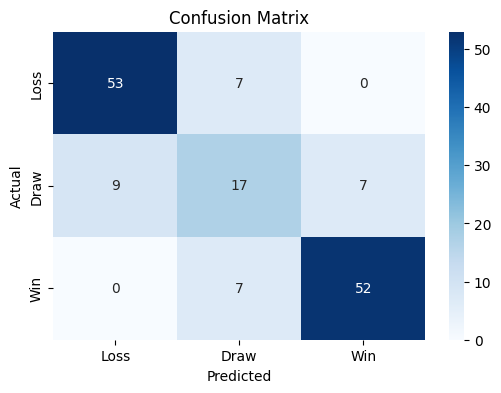

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#confusion matrix will show where the model gets things wrong most
cm = confusion_matrix(y_test, y_pred)

#heatmap will make visualization of accuracy easier
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Loss", "Draw", "Win"], yticklabels=["Loss", "Draw", "Win"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
#map shows that the model struggles most with wins/losses vs draws and never predicts a win when there's a loss or vice versa

In [64]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, target_names=["loss", "draw", "win"])
print(report) #as expected, the modal struggles to predict draws, which is reasonable because that is difficult even for people

              precision    recall  f1-score   support

        loss       0.85      0.88      0.87        60
        draw       0.55      0.52      0.53        33
         win       0.88      0.88      0.88        59

    accuracy                           0.80       152
   macro avg       0.76      0.76      0.76       152
weighted avg       0.80      0.80      0.80       152

